<a href="https://colab.research.google.com/github/nbche/AIFFEL_quest_cr/blob/main/MainQuest03_14_Jan_2025_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**페렴아 기다려라!**

  < 목 차 >

Step 1. 데이터 준비 단계

Step 2. Base 모델로서의 CNN 모델 구현

Step 3. CNN 모델 학습하기

**Step 4. Base 모델 학습/테스트 결과**

Step 5. 데이터 증강

Step 6. 증강된 데이터셋트를 Base 모델에 적용하기

**Step 7. 보강 데이터를 추가한 CNN 모델 결과 비교 (Step 4와 Step 6 간의 비교)**

Step 8. 수정 CNN 모델 (모델 구조 변경)

Step 9. 증강된 데이터 셋트를 수정 CNN 모델에 적용하기

**Step 10. 수정 CNN 결과 비교 (Step 7 과 Step 10 간의 비교)**

Step 11. RES-NET 18 모델

Step 12. 증강된 데이터 셋트를 RES-NET 18 모델에 적용하기

**Step 13. RES-NET 18 결과 비교 (Step 10 과 Step 13 간의 비교)**

결론

회고

----------------------------------------------------------------------------------------------------------------------------------------------------------------

*Step 1. 데이터 준비 단계*


*   데이터 세트 : Keggle 출처의 페렴 X- RAY 자료
*   데이터셋 사이즈 (원안): 훈련용 (5,216), 테스트용 (624), 검토용 (16)
*   데이터셋 사이즈 (수정안): 훈련용 (4,185), 테스트용 (624), 검토용 (1,047)
*   훈련용 데이터 내 양성 (페렴) 데이터수 : 3,115 건 (74% 로 Data Imbalance 가능성 농후)
*   데이터셋 이미지 사이즈 : 180,180,3

In [3]:
## Step 1-1. Dataset 불러오기

import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:25<00:00, 96.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [4]:
## Step 1-2. 패키지 목록 불러오기

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')


In [5]:
## Step 1-3. 변수 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
TRAIN_PATH = path + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = path + '/chest_xray/val/*/*'
TEST_PATH = path + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(path)

/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [6]:
## Step 1-4. 데이터 가져오기

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [7]:
## Step 1-5. Validation Data 추가 생성

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [8]:
## Step 1-6. 이미지 경로 확인

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0547-0001.jpeg
Pneumonia image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1454_bacteria_3782.jpeg


In [9]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1069
Pneumonia images count in training set: 3116


이미지의 결과물 숫자가 LMS 와 다름. LMS 에서는 Normal 1070, Pneumonia 3115 임

In [10]:
## Step 1-7. 미니배치 만들기

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
## Step 1-8. 데이터셋 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [12]:
## Step 1-9. 라벨 데이터 만들기

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
   # return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)
   # Colabe 실행을 위해 기존 코딩을 변경
    return tf.cond(parts[-2] == "PNEUMONIA", lambda: tf.constant(1.0, dtype=tf.float32), lambda: tf.constant(0.0, dtype=tf.float32))   # 폐렴이면 양성(1.0), 노말이면 음성(0.0)

In [13]:
## Step 1-10. 이미지 변형/ 가공한 데이터 불러오기

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [14]:
## Step 1-11. 데이터셋트 만들기

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(len(train_ds))
print(len(val_ds))

4185
1047


In [15]:
## Step 1-12. 데이터셋 내용 확인

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0.0


In [16]:
## Step 1-13. 테스트용 데이터셋 만들기

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [17]:
## Step 1-14. prepare_for_training 함수 정의

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

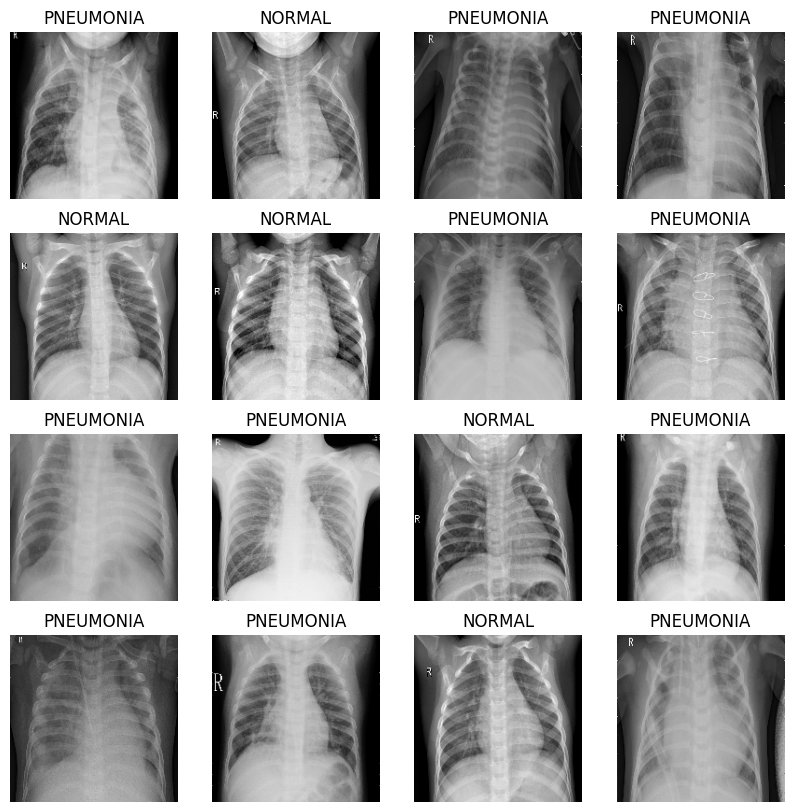

In [ ]:
## Step 1-15. 데이터 시각화

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

----------------------------------------------------------------------------------------------------------------------------------------------------------------

*Step 2. Base 모델로서의 CNN 모델 구현*

In [18]:
## Step 2-1. Convolution block 생성

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [19]:
## Step 2-2. Dense block 생성

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [20]:
## Step 2-3. model 만들기

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [21]:
## Step 2-4. weight 조정하기
# weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [23]:
## Step 2-5. model 만들기 : 모델 요약

model = build_model()
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 45, 45, 32)          │           2,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 22, 22, 64)          │           7,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 11, 11, 128)         │          27,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 5, 5, 256)           │         103,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 512)                 │       3,279,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ (None, 128)                 │          66,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 64)                  │           8,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,496,801 (13.34 MB)

 Trainable params: 3,494,433 (13.33 MB)

 Non-trainable params: 2,368 (9.25 KB)

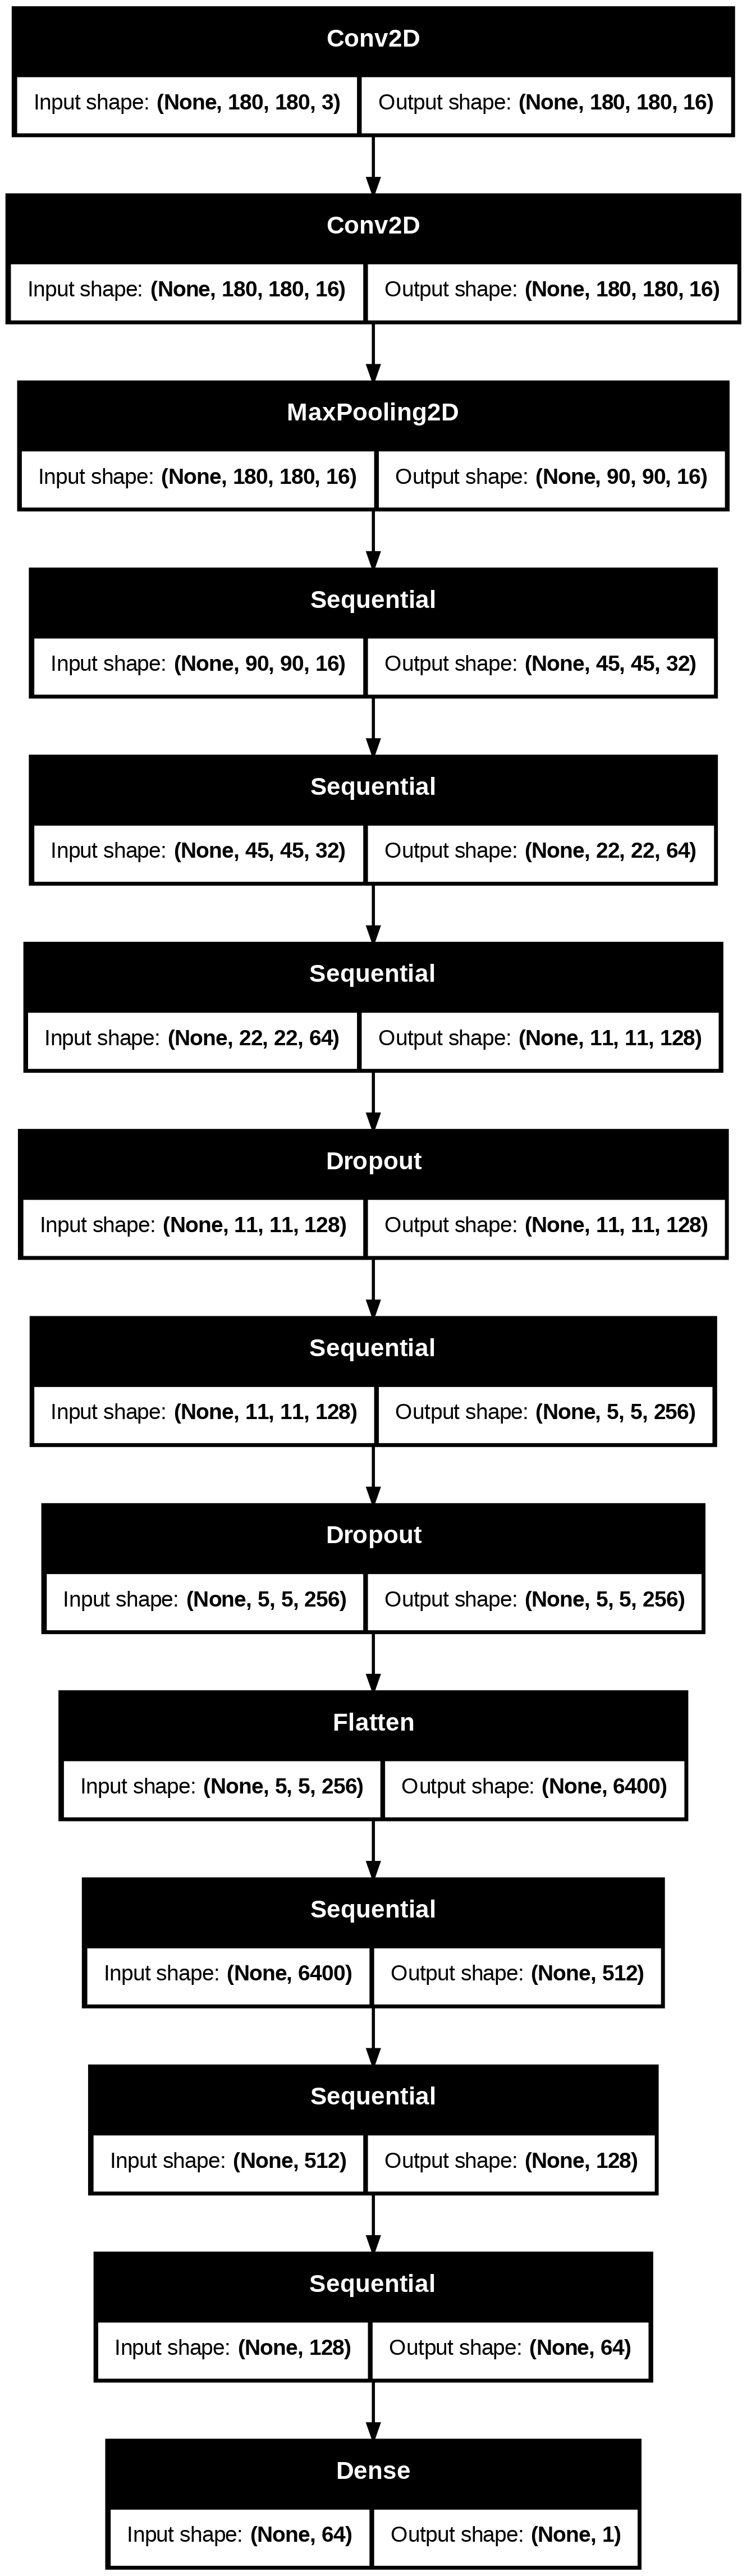

In [24]:
## Step 2-6. model 만들기 : 모델 도식화

from tensorflow.keras.utils import plot_model # 모델 시각화
plot_model(model, show_shapes=True, to_file='model.png')

----------------------------------------------------------------------------------------------------------------------------------------------------------------

*Step 3. CNN 모델 학습하기*

In [ ]:
## Step 3. 모델 컴파일 하기

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
## Step 3. 모델 학습하기

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.7601 - loss: 0.4752 - precision: 0.9303 - recall: 0.7332 - val_accuracy: 0.7365 - val_loss: 0.6963 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.9142 - loss: 0.2287 - precision: 0.9744 - recall: 0.9088 - val_accuracy: 0.7356 - val_loss: 1.6315 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.9299 - loss: 0.1777 - precision: 0.9758 - recall: 0.9292 - val_accuracy: 0.9365 - val_loss: 0.1519 - val_precision: 0.9234 - val_recall: 0.9961
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.9317 - loss: 0.1897 - precision: 0.9808 - recall: 0.9284 - val_accuracy: 0.9538 - val_loss: 0.1156 - val_precision: 0.9723 - val_recall: 0.9647
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.9369 - loss: 0.1641 - precision: 0.9788 - recall: 0.9353 - val_accuracy: 0.9413 - val_los

----------------------------------------------------------------------------------------------------------------------------------------------------------------

*Step 4. Base 모델 학습/테스트 결과*

*   Base 모델로 합성곱 모델을 선택함
*   기본 모델은 배치 사이즈를 16으로 하고, Epoch 를 10회로 함
*   제공된 모델은 6번의 파라미터 연산을 하는 Conv 구조를 가지며, FCN 모델은 3개의 은닉층과 1개의 출력층으로 구성됨
*   페렴의 양성 (보유) 과 음성(정상) 판별하는 이진 분류이기에 Sigmoid 를 활성화 함수로 함
*   모델 테스트 결과는 아래와 같음

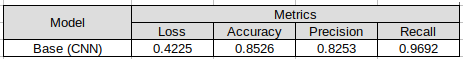

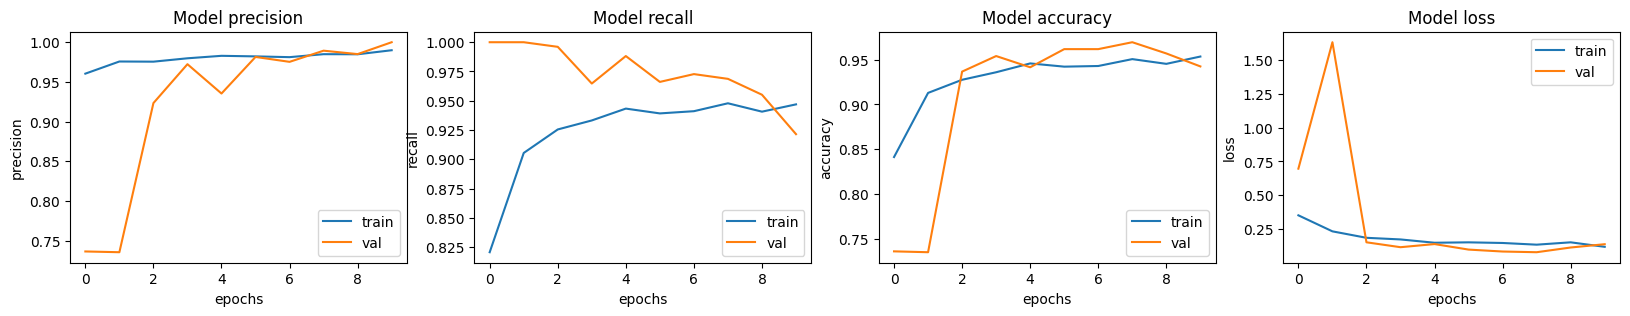

In [ ]:
## Step 4-1. 결과 도식화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
## Step 4-2. 테스트 데이터로 결과 평가

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 468ms/step - accuracy: 0.8515 - loss: 0.4375 - precision: 0.8165 - recall: 0.9654
Loss: 0.4225054979324341,
Accuracy: 0.8525640964508057,
Precision: 0.8253275156021118,
Recall: 0.9692307710647583


----------------------------------------------------------------------------------------------------------------------------------------------------------------

*Step 5. 데이터 증강*

In [ ]:
## Step 5-1. 사용 모듈 버젼 확인하기

import tensorflow

print(tensorflow.__version__)

2.17.1


In [ ]:
## Step 5-2. 데이터 증강 함수 augement 생성

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    image = tf.image.random_brightness(image, max_delta=0.2) # 가우시안 노이즈 추가
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

데이터 증강을 통해 데이터셋이 얼마나 늘어나는지를 보려는 목적으로 아래 함수 추가함

In [ ]:
print(len(train_ds))
print(len(val_ds))

TypeError: The dataset is infinite.

아래와 같이 Data Augmentation  요소를 더 추가해 보려 했으나 성공하지 못함

In [ ]:
!pip install tensorflow-addons==0.16.1

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전

    image = tf.keras.preprocessing.image.random_rotation(
        image.numpy(),
        30, # 랜덤하게 이미지를  -30 와  30 도 사이로 회전
        row_axis=0,
        col_axis=1,
        channel_axis=2,
        fill_mode='nearest'
    )
    image = tf.convert_to_tensor(image)


    image = tf.keras.preprocessing.image.random_zoom(
        image.numpy(),
        (0.8, 1.2),  # 랜덤하게 이미지를 80% 과 120% 사이즈에서 줌 처리함
        row_axis=0,
        col_axis=1,
        channel_axis=2,
        fill_mode='nearest'
    )
    image = tf.convert_to_tensor(image)

    return image, label

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.19.0
    Uninstalling tensorflow-addons-0.19.0:
      Successfully uninstalled tensorflow-addons-0.19.0


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'AbstractRNNCell'

---------------------------------------------------------------------------------------------------------------------------------------------------------------

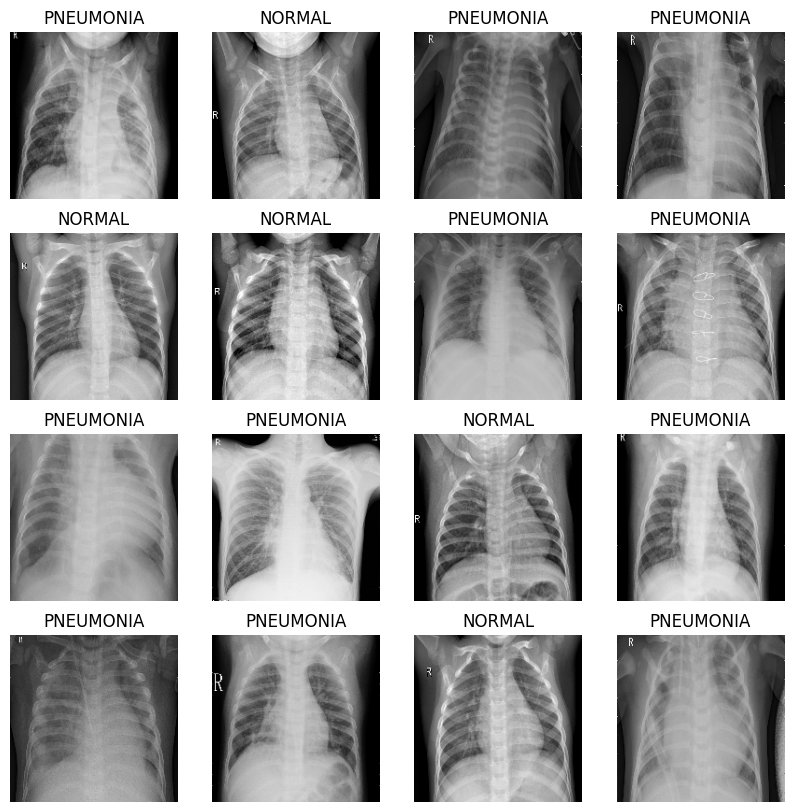

In [ ]:
## Step 5-3. 증강 데이터 시각화 (1): Show_batch 함수 사용
show_batch(image_batch.numpy(), label_batch.numpy())   # 기존의 show batch 를 통해서 Augmentation 이 반영된 결과를 볼 수가 없음. 따라서 다른 함수를 사용키로 함

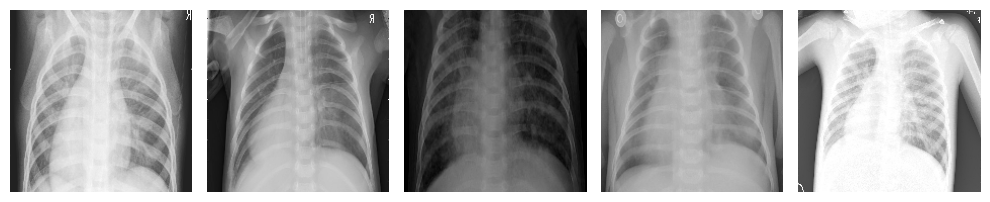

In [ ]:
## Step 5-4. 증강 데이터 시각화 (2) : PlotImages 함수 사용

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img[0])  # img[0] 를 통해 16개 배치에서 가장 첫번째 이미지만 보여줌
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# train_ds에서 5개의 이미지와 라벨을 가져오기.
image_batch, label_batch = next(iter(train_ds.take(1))) # train_ds.take(1)을 사용하여 첫 번째 배치를 가져옵니다.

# Augumentation 함수를 선택된 각 이미지에 적용합니다.
augmented_images = [augment(image, label)[0] for image, label in zip(image_batch, label_batch)]
# augmented_images는 이제 증강된 이미지의 리스트입니다.

# augmented_images를 Plot Images 함수를 통해 시각화합니다.
plotImages(augmented_images[:5]) # augmented_images를 plotImages 함수에 전달합니다.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

*Step* 6.  증강된 데이터셋트를 Base 모델에 적용하기

In [ ]:
## Step 6-1. 증강 데이터를 추가하여 CNN 모델 : 학습하기

with tf.device('/GPU:0'):
    history_2 = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9534 - loss: 0.1194 - precision: 0.9880 - recall: 0.9491 - val_accuracy: 0.9510 - val_loss: 0.1119 - val_precision: 0.9672 - val_recall: 0.9660
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.9498 - loss: 0.1194 - precision: 0.9896 - recall: 0.9426 - val_accuracy: 0.8510 - val_loss: 0.5097 - val_precision: 0.9967 - val_recall: 0.7987
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.9279 - loss: 0.1923 - precision: 0.9766 - recall: 0.9251 - val_accuracy: 0.9413 - val_loss: 0.1611 - val_precision: 0.9356 - val_recall: 0.9882
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.9466 - loss: 0.1350 - precision: 0.9833 - recall: 0.9442 - val_accuracy: 0.9654 - val_loss: 0.0857 - val_precision: 0.9704 - val_recall: 0.9831
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.9444 - loss: 0.1472 - precision: 0.9883 - recall: 0.9372 - val_accuracy: 0.9673 - val_los

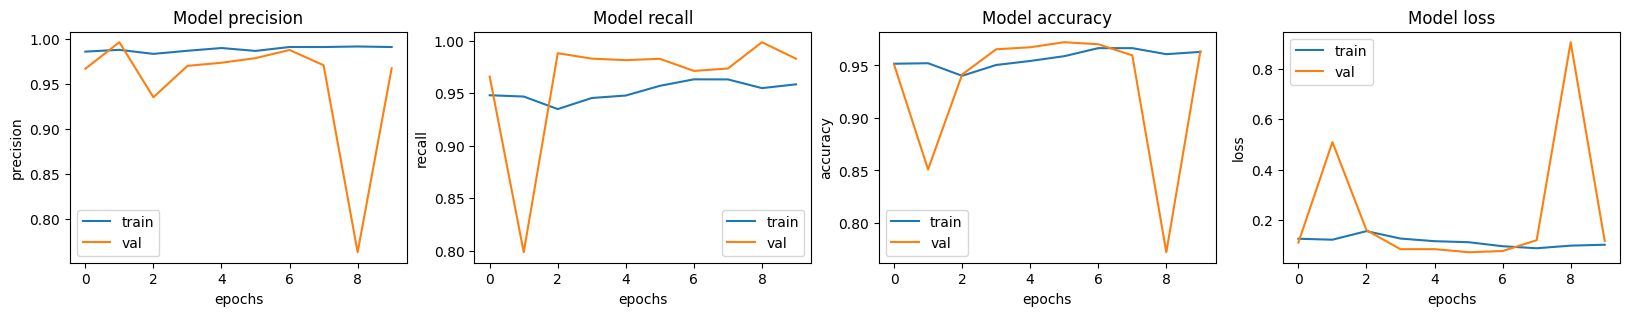

In [ ]:
## Step 6-2. 증강 데이터를 추가하여 CNN 모델 : 도식화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_2.history[met])
    ax[i].plot(history_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
## Step 6-3. 증강 데이터를 추가하여 CNN 모델 : 테스트 결과

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 526ms/step - accuracy: 0.7656 - loss: 1.1462 - precision: 0.7238 - recall: 0.9974
Loss: 1.1589126586914062,
Accuracy: 0.7692307829856873,
Precision: 0.731203019618988,
Recall: 0.9974358677864075


----------------------------------------------------------------------------------------------------------------------------------------------------------------

Step 7.  증강 데이터를 추가한 CNN 모델 결과 비교
(Step  4와 Step 6 간의 비교)

*   고정된 자세로 X-Ray 가 찍히는 연유로, 데이터의 자유로운 변환이 크게 의미가 없는 경우임.
*   그럼에도 X-Ray 가 적용 가능한 좌우 반전 (flip_left_right) 과 가우시안 노이즈를 적용함
*   기본 모델 대비 Loss 가 증가하며 학습력이 떨어졌지만, 오히려 Recall 이 증가함을 알 수 있음





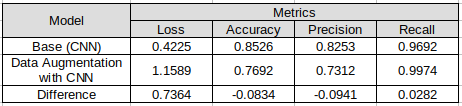

1) CNN 모델 결과

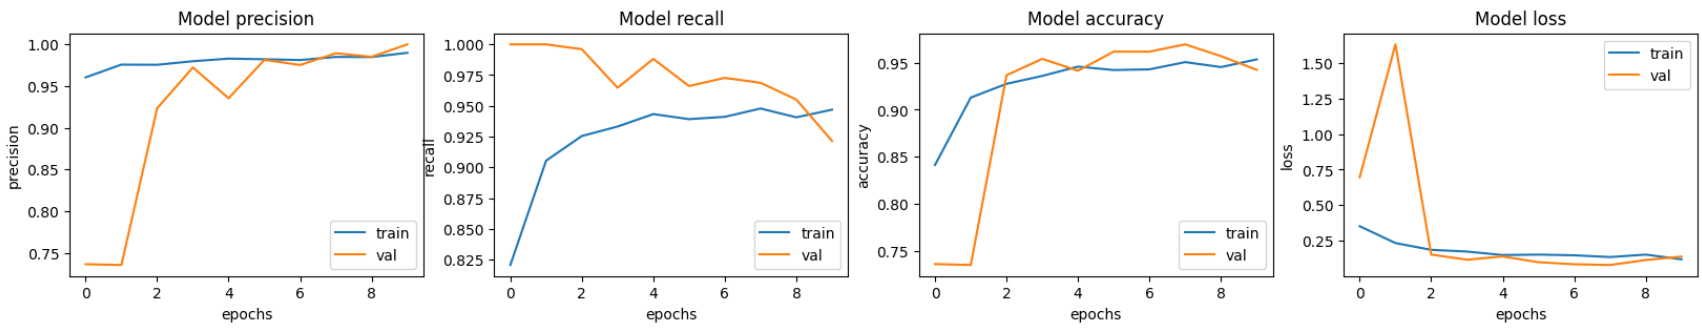

2) 증강 데이터를 반영한 CNN 결과

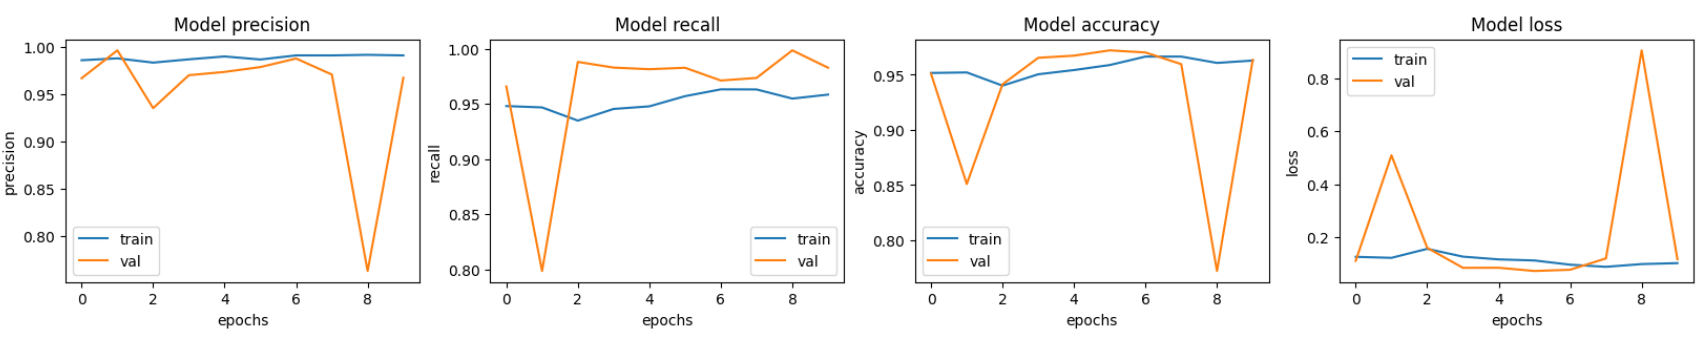

----------------------------------------------------------------------------------------------------------------------------------------------------------------


Step 8. 수정 CNN 모델 (모델 구조 변경)



아래과 같은 변경이 CNN 모델에 적용됨

* Epoch 를 5로 줄임 (CNN 결과 리뷰 후, 6회 이상의 학습이 학습률 변동에 미미하게 효과를 보임)  
*   Conv_block 에서 1*1 사이즈의 커넬을 추가함 (작은 사이즈의 커넬로 정보를 촘촘히 읽어 내기 위하여)
*   Dense_block 에서 Drop out 을 적용치 않음 (Drop out 이 배치 정규화와 같이 적용시 부정적 영향을 끼칠 수 있다는 학계 가설에 따라서)
*  optimizer 는 변동치 않고, 대신 Adam 의 학습률을 기본 0.001 에서 0.002 로 변경함





In [25]:
## Step 8-1. 모델 구조 변경 : 하이퍼파라미터 조정

BATCH_SIZE = 16   #  배치 사이즈가 모델에 끼치는 영향의 장,단점이 공존하는바, 일단 Batch size 는 변경치 않도록 함
EPOCHS = 5  # 모델의 성능을 확인하는 metrics 를 확인해 보면, base 모델에서 Epoch 이 5 이상인 경우, 학습력의 개선이 보이지 않음. 따라서 Epoch 를 줄이도록 함

In [26]:
## Step 8-2. 모델 구조 변경 : Convolution block 수정

def conv_block(filters):
    block = tf.keras.Sequential([

        tf.keras.layers.SeparableConv2D(filters, 1, activation='relu', padding='same'), # 1x1 사이즈의 kernel을 이용하는 layer 추가
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [27]:
## Step 8-3. 모델 구조 변경 : Dense block 수정

def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
      # tf.keras.layers.Dropout(dropout_rate)    # BatchNormalisation 와 병행하는 것에 대한 학계 이론을 반영하여 Drop-out 사용치 않음
    ])


    return block

In [28]:
## Step 8-4. 모델 구조 변경 : 수정 CNN 모델 함수

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512),
        dense_block(128),
        dense_block(64),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [29]:
## Step 8-5. 모델 구정 변경 : 수정 CNN 모델 요약
model = build_model()
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (None, 45, 45, 32)          │           3,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 22, 22, 64)          │          11,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_10 (Sequential)           │ (None, 11, 11, 128)         │          44,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_11 (Sequential)           │ (None, 5, 5, 256)           │         170,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 512)                 │       3,279,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 128)                 │          66,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_14 (Sequential)           │ (None, 64)                  │           8,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,586,721 (13.68 MB)

 Trainable params: 3,584,353 (13.67 MB)

 Non-trainable params: 2,368 (9.25 KB)

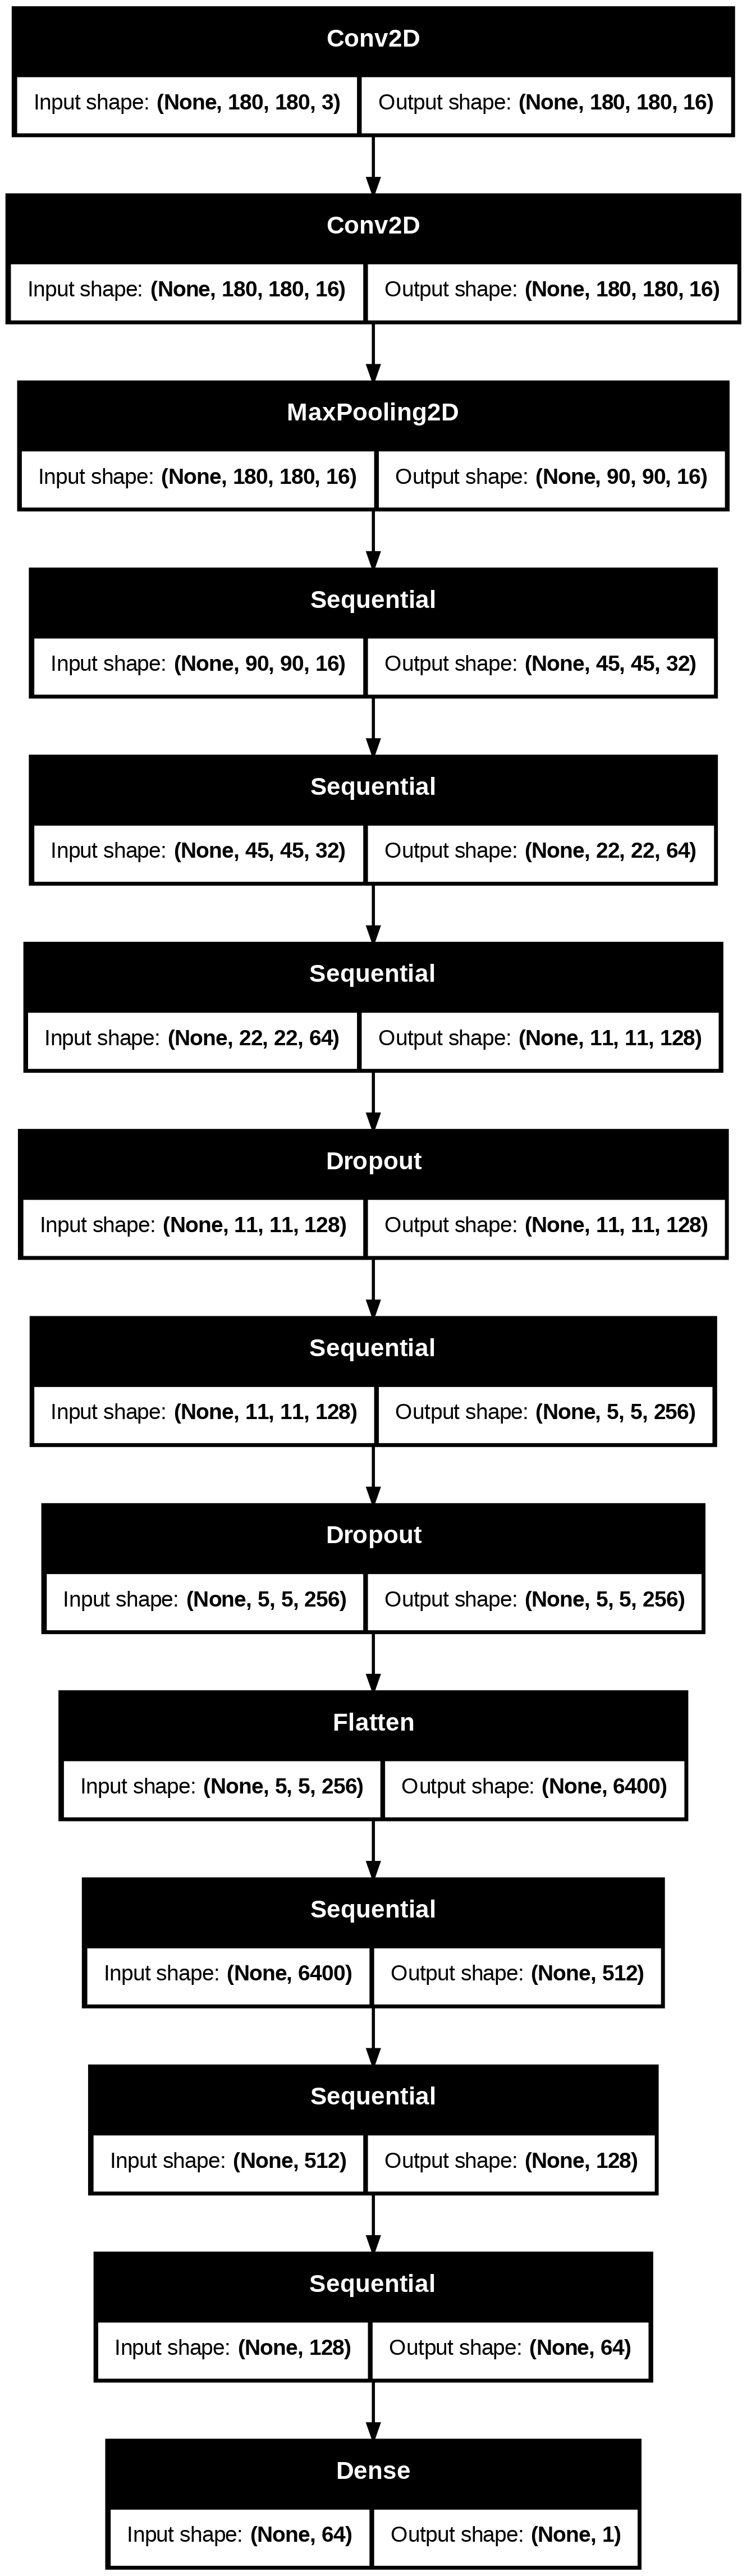

In [30]:
## Step 8-6. model 만들기 : 수정 CNN 모델 도식화

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

In [ ]:
## Step 8-7. 모델 구조 변경 : 모델 컨파일하기

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), # Adam 의 기본 학습률인 0.001 에서 0.002 로 변경
        loss='binary_crossentropy',
        metrics=METRICS
    )

----------------------------------------------------------------------------------------------------------------------------------------------------------------

Step 9. 증강된 데이터 셋트를 수정 CNN 모델에 적용하기

In [ ]:
## Step 9-1. 수정 CNN 모델 : 학습하기

with tf.device('/GPU:0'):
    history_3 = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.5148 - loss: 0.8454 - precision: 0.7543 - recall: 0.5096 - val_accuracy: 0.2663 - val_loss: 1.8107 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.8214 - loss: 0.4020 - precision: 0.9352 - recall: 0.8129 - val_accuracy: 0.7490 - val_loss: 0.8181 - val_precision: 0.7470 - val_recall: 0.9948
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.8993 - loss: 0.2648 - precision: 0.9585 - recall: 0.9026 - val_accuracy: 0.9337 - val_loss: 0.2230 - val_precision: 0.9604 - val_recall: 0.9492
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.9231 - loss: 0.2090 - precision: 0.9679 - recall: 0.9276 - val_accuracy: 0.8971 - val_loss: 0.2430 - val_precision: 0.9809 - val_recall: 0.8766
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.9359 - loss: 0.1664 - precision: 0.9824 - recall: 0.9311 - val_accuracy: 0.8913 - val_

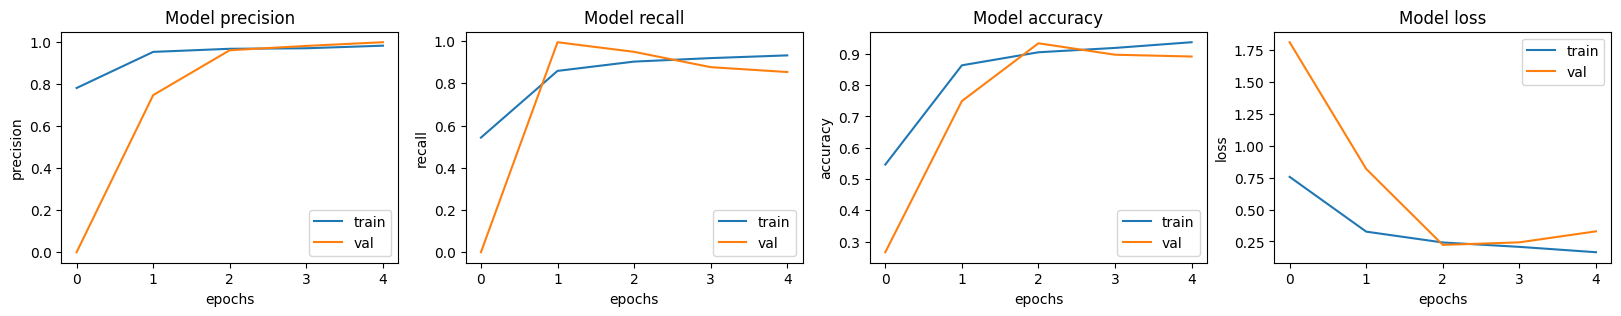

In [ ]:
## Step 9-2. 수정 CNN 모델 : 학습 결과 도식화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_3.history[met])
    ax[i].plot(history_3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
## Step 9-3. 수정 CNN 모델 : 테스트 결과

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 669ms/step - accuracy: 0.8455 - loss: 0.4445 - precision: 0.8670 - recall: 0.8992
Loss: 0.5067028999328613,
Accuracy: 0.8333333134651184,
Precision: 0.8421052694320679,
Recall: 0.9025641083717346


----------------------------------------------------------------------------------------------------------------------------------------------------------------

Step 10. 수정 CNN 결과 비교 (Step 7 과 Step 10 간의 비교)

*   수정 CNN 역시 증강 데이터셋을 사용
*   기본 모델 대비 손실이 크게 감소함 (1.1 -> 0.5)
*   의료 데이터에서 중요한 Recall 의 이전 모델보다 낮아졌다는 아쉬움이 있음
*   2번째 Epoch 이후에 과적합이 나타나는 양상임



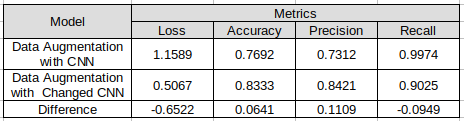

1) CNN 모델 결과

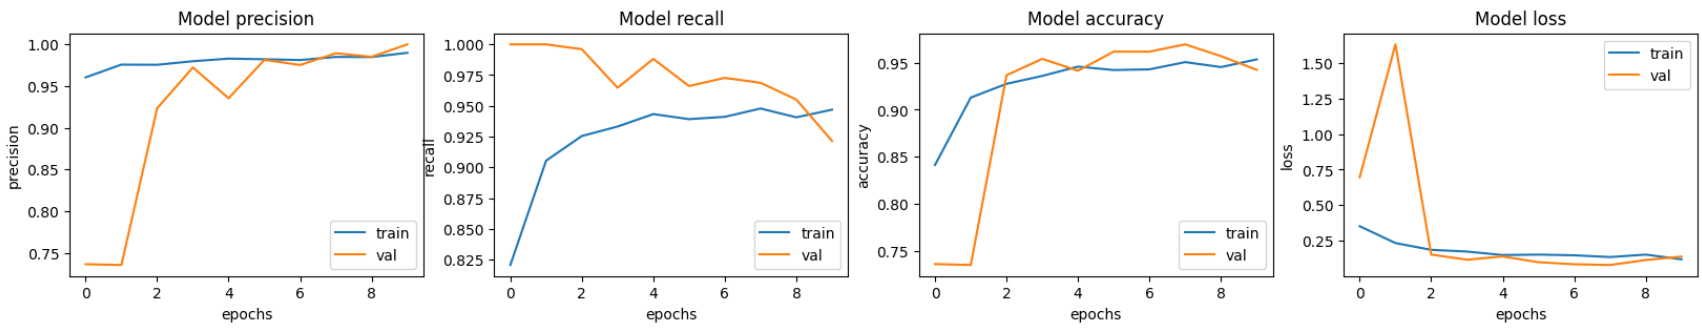

2) 증강 데이터를 반영한 CNN 결과

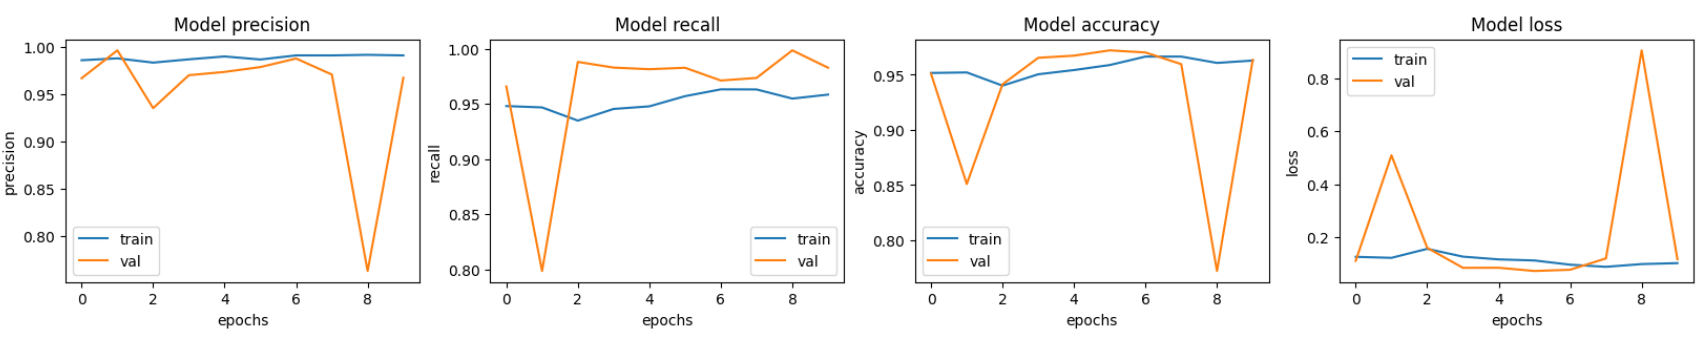

3) 수정 CNN 결과 (증강 데이터셋 이용)

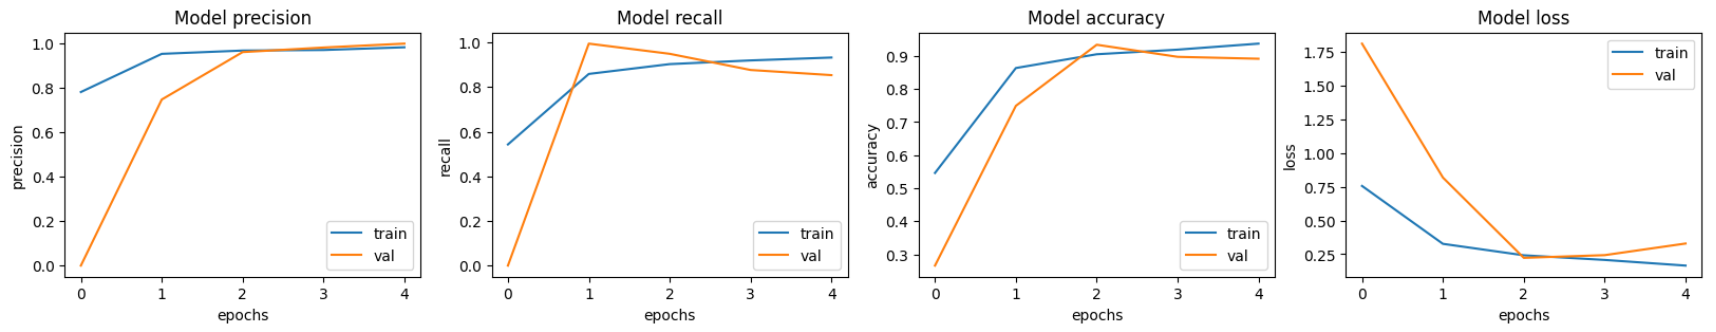

----------------------------------------------------------------------------------------------------------------------------------------------------------------

Step 11. RES-NET 18 모델

In [ ]:
## Step 11-1. RES-NET 18 모델: 모델 설정 (1)

# Source : https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py
# Adapted from https://github.com/pytorch/vision/blob/v0.4.0/torchvision/models/resnet.py

import math
from tensorflow import keras
from tensorflow.keras import layers

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

In [ ]:
## Step 11-2. RES-NET 18 모델 (1):  모델 구조 확인
model.summary()

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_57            │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 186, 186, 3)    │              0 │ input_layer_57[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 90, 90, 64)     │          9,408 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1 (BatchNormalization)  │ (None, 90, 90, 64)     │            256 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu1 (ReLU)              │ (None, 90, 90, 64)     │              0 │ bn1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool_pad               │ (None, 92, 92, 64)     │              0 │ relu1[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ maxpool (MaxPooling2D)    │ (None, 45, 45, 64)     │              0 │ maxpool_pad[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1.0.conv1_pad        │ (None, 47, 47, 64)     │              0 │ maxpool[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1.0.conv1 (Conv2D)   │ (None, 45, 45, 64)     │         36,864 │ layer1.0.conv1_pad[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1.0.bn1              │ (None, 45, 45, 64)     │            256 │ layer1.0.conv1[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1.0.relu1 (ReLU)     │ (None, 45, 45, 64)     │              0 │ layer1.0.bn1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1.0.conv2_pad        │ (None, 47, 47, 64)     │              0 │ layer1.0.relu1[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1.0.conv2 (Conv2D)   │ (None, 45, 45, 64)     │         36,864 │ layer1.0.conv2_pad[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1.0.bn2              │ (None, 45, 45, 64)     │            256 │ layer1.0.conv2[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1.0.add (Add)        │ (None, 45, 45, 64)     │              0 │ maxpool[0][0],         │
│                           │                        │                │ layer1.0.bn2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer1.0.relu2 (ReLU)     │ (None, 45, 45, 64)     │              0 │ layer1.0.add[0][0]     │
├──────────────────────

 Total params: 11,699,112 (44.63 MB)

 Trainable params: 11,689,512 (44.59 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
## Step 11-3. RES-NET 18 모델 (1) : 모델 도식화

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

위의 과정을 수행 중에 Tensorflow 에서 제공하는 ResNet 18을 확인하게 되어 위의 모델은 적용치 않음

----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [31]:
## Step 11-4. RES-NET 18 모델 (2): 적용하기

!pip install tensorflow # install latest stable tensorflow
!pip install git+https://github.com/qubvel/classification_models.git

import tensorflow as tf
from tensorflow import keras
from classification_models.tfkeras import Classifiers

# Get the ResNet18 model from the classification_models library
ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), weights='imagenet', include_top=False)

# Add your custom layers
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

# Create the final model
model = keras.Model(inputs=base_model.input, outputs=outputs)

# Compile the model
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-3rqjq8py
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-3rqjq8py
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
  Created wheel for image_classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20029 sha256=cc56c4deea1daf2e7c4761e13bfe58e585720ce49f82ae334a8b37bb768da1ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-mie3h8b3/wheels/f5/13/cb/b1dbd79043c5a389742e422859b0b663adcd7b5c220928c339
Successfully built image_classifiers
44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [32]:
## Step 11-4. RES_NET 18 모델 : 모델 요약

model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, 180, 180, 3)    │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 186, 186, 3)    │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, 90, 90, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, 90, 90, 64)     │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, 90, 90, 64)     │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 92, 92, 64)     │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, 45, 45, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, 45, 45, 64)     │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, 45, 45, 64)     │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 47, 47, 64)     │              0 │ stage1_unit1_relu1[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, 45, 45, 64)     │         36,864 │ zero_padding2d_2[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, 45, 45, 64)     │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, 45, 45, 64)     │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 47, 47, 64)     │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding2D)      

 Total params: 11,187,402 (42.68 MB)

 Trainable params: 11,179,460 (42.65 MB)

 Non-trainable params: 7,942 (31.02 KB)

In [33]:
## Step 11-5. RES-NET 18 모델 : 모델 도식화

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

----------------------------------------------------------------------------------------------------------------------------------------------------------------

Step 12. 증강된 데이터 셋트를 RES-NET 18 모델에 적용하기

In [ ]:
## Step 12-1. RES-NET 18 모델 : 학습하기

with tf.device('/GPU:0'):
    history_4 = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 1126s 4s/step - accuracy: 0.9046 - loss: 0.2747 - precision: 0.9696 - recall: 0.8998 - val_accuracy: 0.7356 - val_loss: 2.0816 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 1057s 4s/step - accuracy: 0.9623 - loss: 0.1022 - precision: 0.9880 - recall: 0.9611 - val_accuracy: 0.7288 - val_loss: 3.1217 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 1062s 4s/step - accuracy: 0.9752 - loss: 0.0667 - precision: 0.9928 - recall: 0.9737 - val_accuracy: 0.7346 - val_loss: 2.5720 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 1055s 4s/step - accuracy: 0.9765 - loss: 0.0558 - precision: 0.9943 - recall: 0.9738 - val_accuracy: 0.9606 - val_loss: 0.0929 - val_precision: 0.9775 - val_recall: 0.9686
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 1056s 4s/step - accuracy: 0.9835 - loss: 0.0400 - precision: 0.9944 - recall: 0.9832 - val_accuracy: 0.9481 - val_los

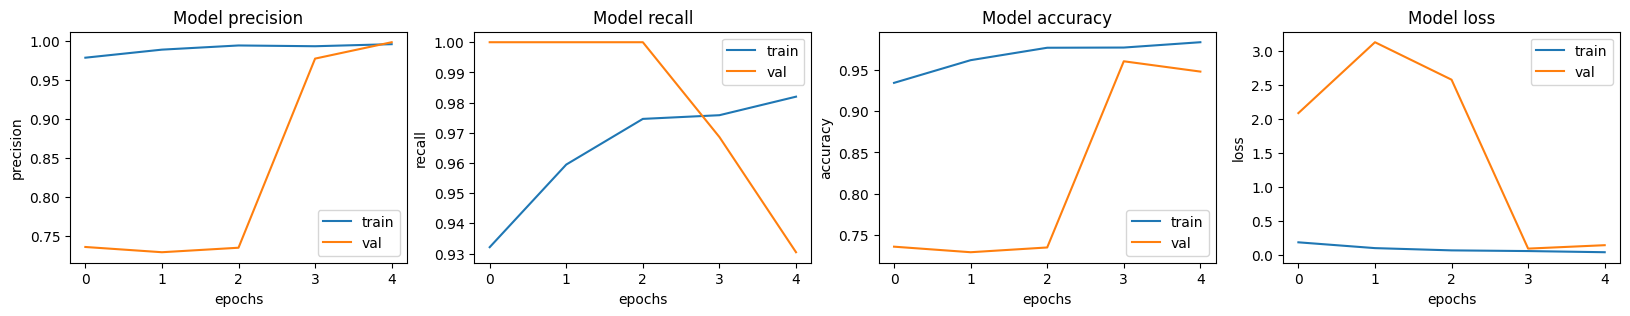

In [ ]:
## Step 12-2. RES_NET 18 모델 : 학습 결과 도식화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_4.history[met])
    ax[i].plot(history_4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
## Step 12-3. RES-NET 18 모델 : 테스트 결과

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8746 - loss: 0.3866 - precision: 0.8456 - recall: 0.9756
Loss: 0.3945360481739044,
Accuracy: 0.8766025900840759,
Precision: 0.8532731533050537,
Recall: 0.9692307710647583


----------------------------------------------------------------------------------------------------------------------------------------------------------------



Step 13. RES-NET 18 결과 비교 (Step 10 과 Step 13 간의 비교)

*   수정 CNN 모델과 동일하게 Epoch 을 5까지 수행함
*   Classifier 로 RES-NET 18 모델의 사용하였고, 다른 어떤 조건도 변경치 않음
*   수정 CNN 대비 손실값과 Recall 값이 모두 개선됨

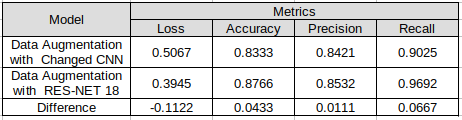

1) CNN 모델 결과

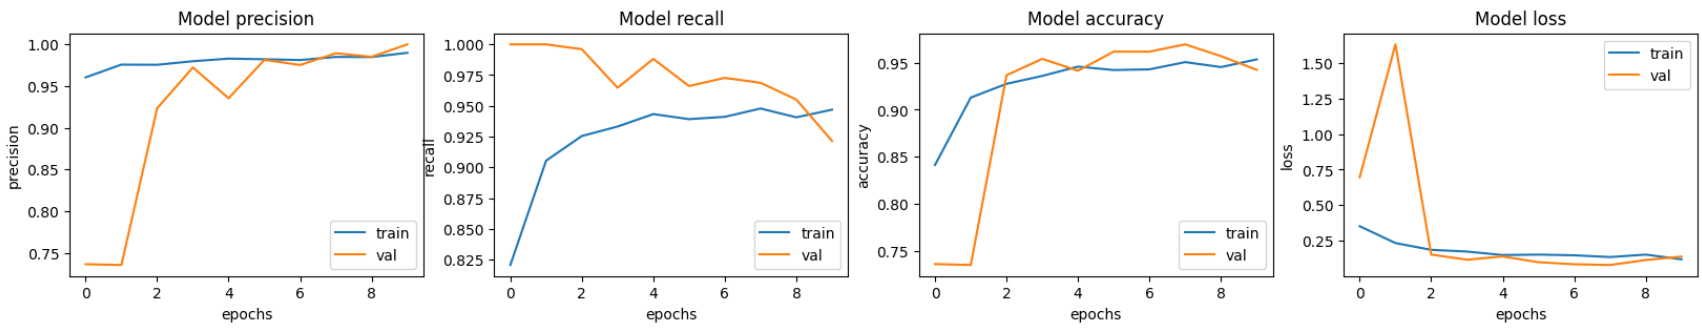

2) 증강 데이터를 반영한 CNN 결과

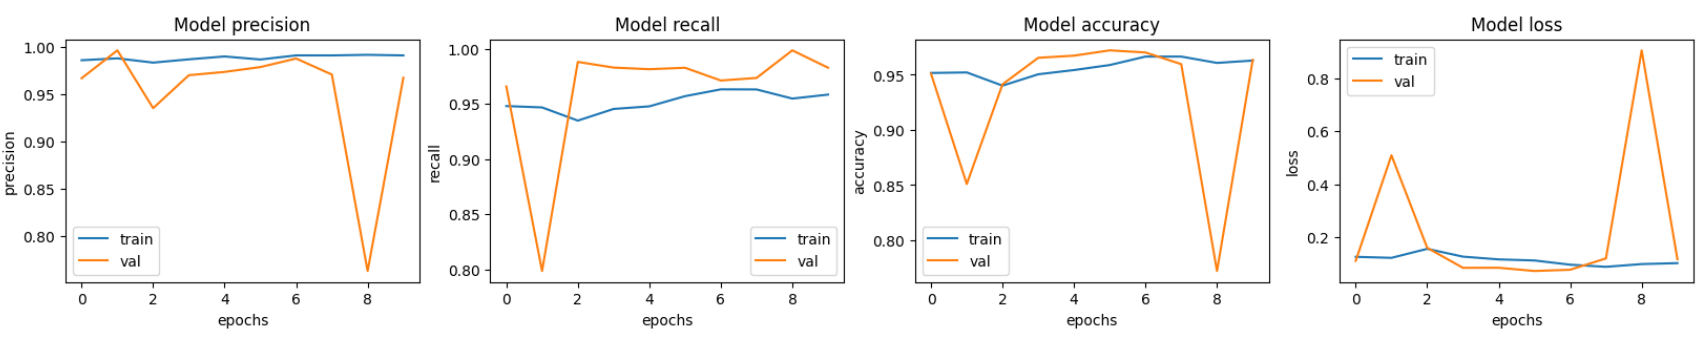


3) 수정 CNN 결과 (증강 데이터 활용)

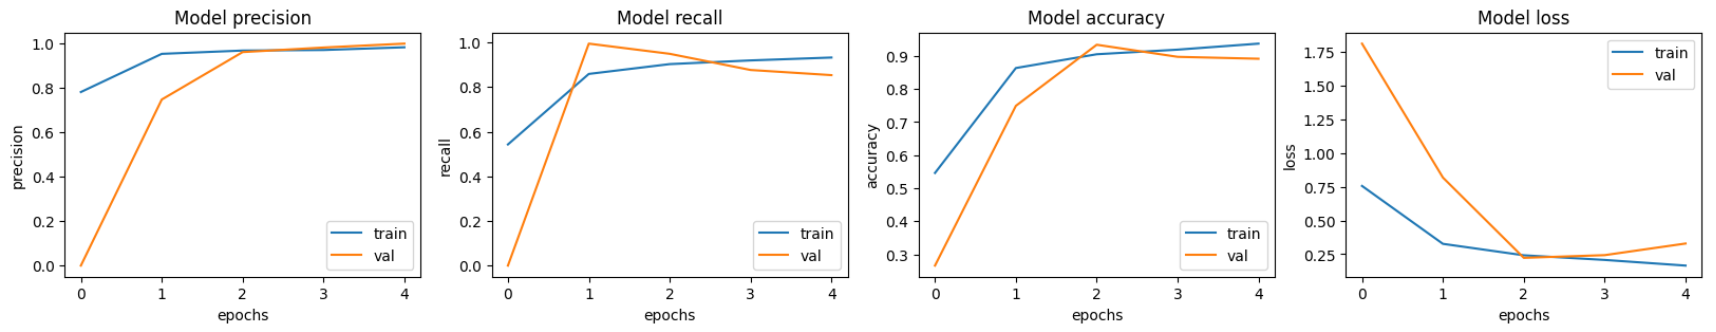

4) RES-NET 18 결과 (증강 데이터 활용)

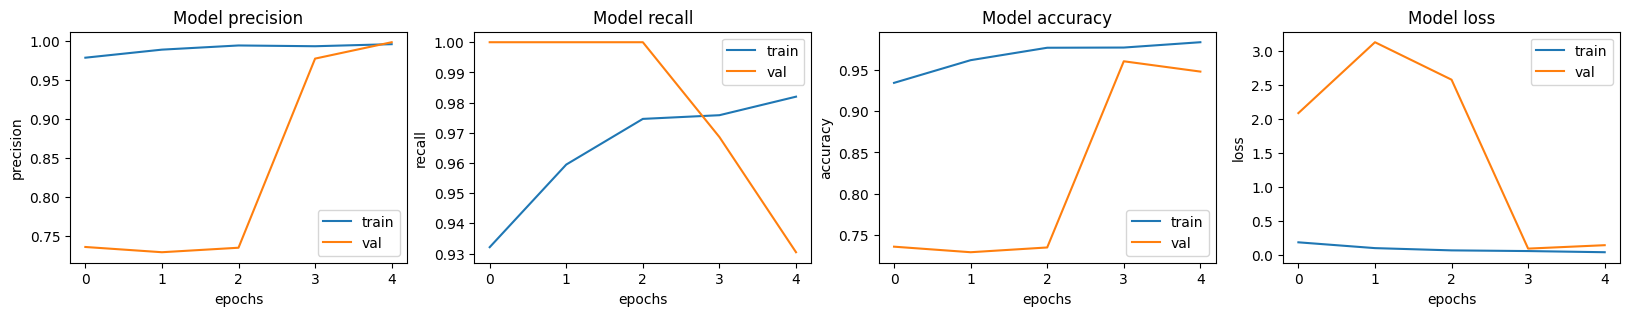

----------------------------------------------------------------------------------------------------------------------------------------------------------------

**결론**



*   영상 의학 자료 데이터 셋트를 가지고 딥러닝을 이용하여 질병 보유 여부를 분류해 해는 퀘스트를 수행함
*   이미지 인식에서 주로 사용하는 CNN 을 기본모델로 하여 아래와 같은 3개의 추가 모델 실행됨

1.   데이터를 증가하여 동일한 모델에 적용해 보기
2.   CNN 의 하이퍼파라미터 및 모델 자체를 변경하여 수정 CNN을 만들기
3.   Skip connection 개념을 적용한 RES-NET 적용해 보기

*   테스트 수행 이후, Metrics 에서 제공하는 4개의 척도에 근거하여 모델을 평가하면, RES-NET 이 본 데이터세트에서 총 3개 영역 (손실, 정확도, 정밀도) 에서 가장 높은 값을 보여줌
*   Recall (양성률에 대한 척도임) 이 CNN 수준으로 값이 나온 부분에 대한 추가 분석이 필요함

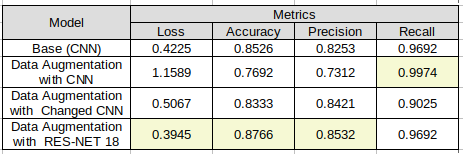

---------------------------------------------------------------------------------------------------------------------------------------------------------------

**회고**


딥러닝으로 시작하는 컴퓨터 비전의 경우, 생경한 주제에 대해 빠른 속도로 교육이 진행되었고, 강의에서 코딩 내용에 대한 설명도 없어서 많이 따라잡기 어려웠습니다. 밑바닥부터 시작하는 딥러닝 읽어 가면서 이해하고 따라가고 있었는데, 퀘스트는 저에게 많은 도전을 주었습니다. 일단은 결과물을 완결할 수 있음에 만족합니다. 레이어가 깊어지니 각층을 분석적으로 이해하기에 압도가 됩니다.

그럼에도 아래와 같은 시도를 해보았습니다.

1. 데이터 증강 결과 이미지 보여주기
증강 데이터 시각화의 경우, Step 1-15 에서 사용한 show batch 대신 plotImages 를 사용함.

Step 1-15. 데이터 시각화 에서 제공된 show-batch 의 경우, 이미지 배치를 입력하면 해당 배치의 16개 이미지가 4*4 로 보여짐. 따라서
Step 5-3 의 결과물을 보면, 보여지는 16개 이미지 중 어떤 것이 증강 데이터인지 확인할 수 없다는 단점이 있음.

증강된 결과물만 보여주지 위해, 일전의 LMS 에서 학습한 plotImages 함수를 사용함 (Step 5-4). 아쉽게도 Label 이 함께 출력되지 않았고, 노출된 이미지로 판단하면 데이터 증강이 눈에 띄게 확실치 않다는 단점이 있음

2. RES-NET 18 모델 다양화 시도

Resnet 18을 인터넷 서칭을 하면서 Py torch 를 통해 Resnet18 을 만드는 경우가 있음을 알게되고, Keras 에서 별도 방식이 제공치 않는 것이라 사료되어 Py torch 방식을 Keras 방식으로 개인이 변형한 모델을 가지고 분석 시작함.  
(## Step 11-1~3. Resnet 18 모델: 모델 설정 (1) 참조 요망)

이후 Keras 의 공식 모델을 확인하게 되어 2개 모델을 파라미터 수치상으로 비교해 보았지만, 큰 차이점은 발견하지 못했음. 퀘스트 과제의 신뢰도를 높이기 위해 Keras 의 모델을 사용키로 함.
(## Step 11-4~5. Resnet 18 모델: 모델 설정 (2) 참조 요망)

2개 모델의 요약과 시작화 자료 역시 해당 Step 에서 확인 가능함

